In [1]:
import os
import numpy as np
import pandas as pd
import torch
import requests
import zipfile
import random
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from timeit import default_timer as timer 

try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

## Getting Data

In [2]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [3]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


## Visualizing Data

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/steak/2979061.jpg
Image class: steak
Image height: 512
Image width: 512


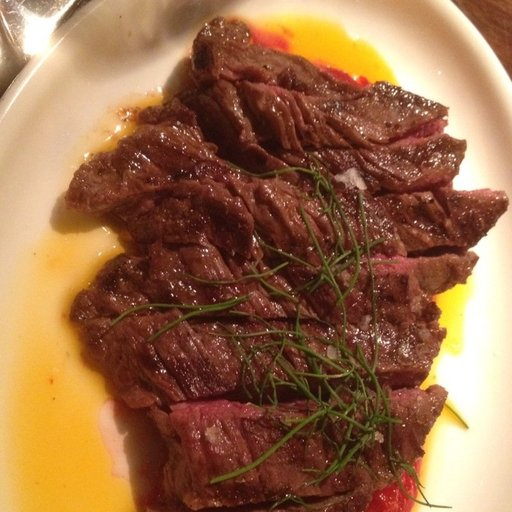

In [6]:
random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

img

## Transforming Data into Dataset of tensors

In [7]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip
    transforms.ToTensor()
])

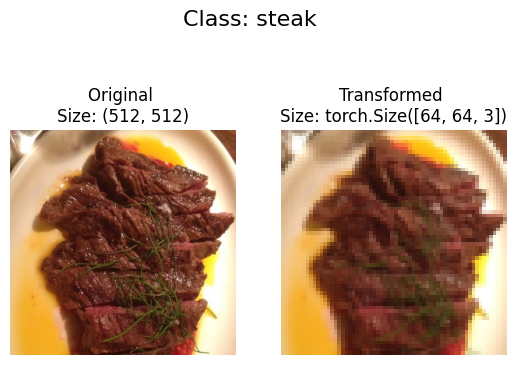

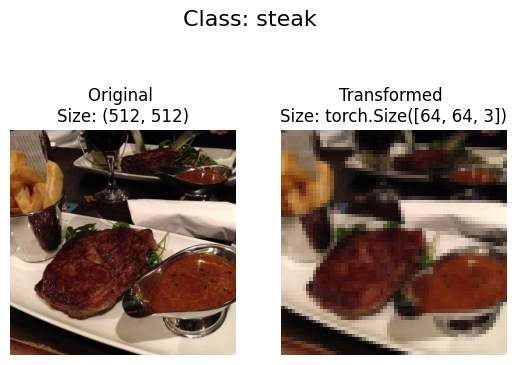

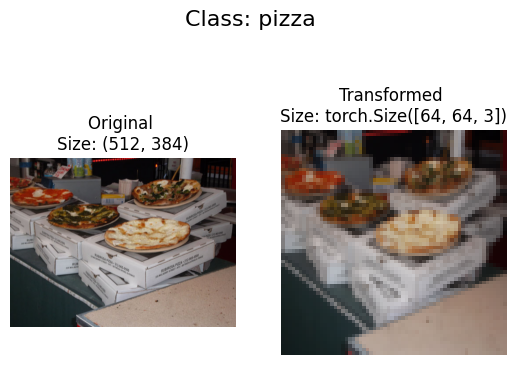

In [8]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform)

## Image Dataset

In [9]:
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform
)

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform
)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [10]:
class_names, class_dict = train_dataset.classes, train_dataset.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [11]:
len(train_dataset), len(test_dataset)

(225, 75)

In [12]:
img, label = train_dataset[0][0], train_dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Text(0.5, 1.0, 'pizza')

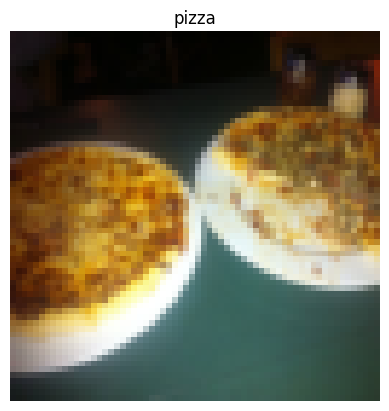

In [13]:
plt.figure()
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(class_names[label])

## DataLoaders

In [14]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=1,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7adad01f4d50>,
 <torch.utils.data.dataloader.DataLoader at 0x7adad1c02090>)

In [15]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Visualizing Data

In [16]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

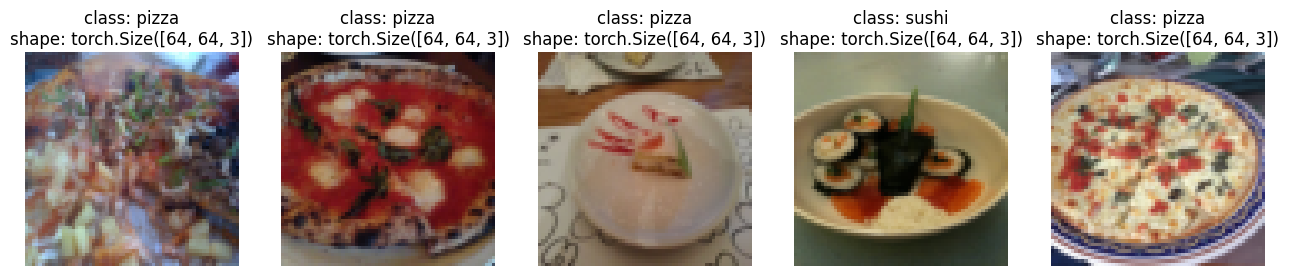

In [17]:
display_random_images(
    train_dataset, 
    n=5, 
    classes=class_names
)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


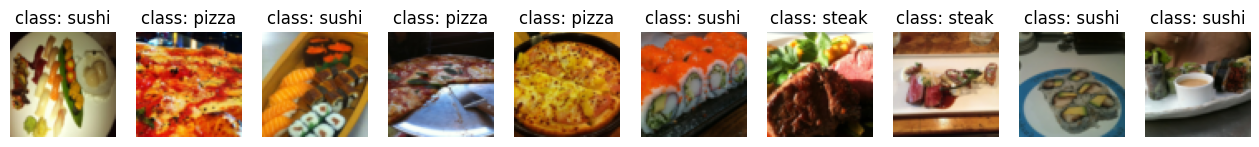

In [18]:
display_random_images(
    test_dataset, 
    n=12, 
    classes=class_names
)

## Testing other types of transfomations

In [19]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

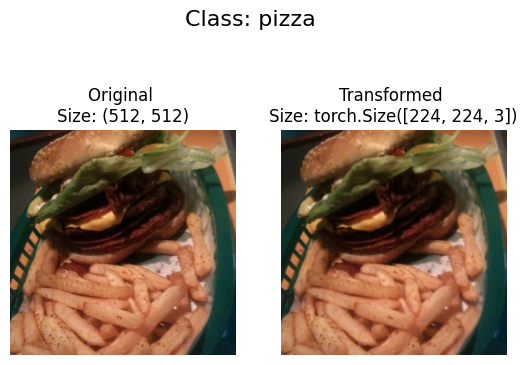

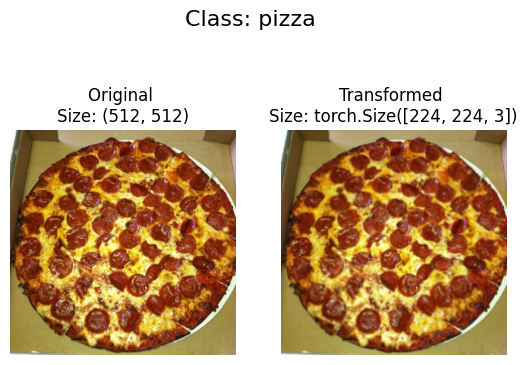

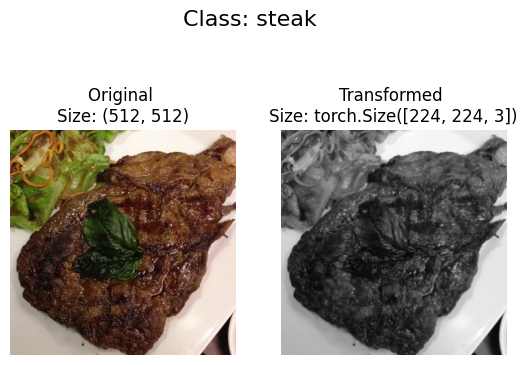

In [20]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## Model Training: Without Data Augmentation

In [21]:
simple_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [22]:
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transforms)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transforms)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader = DataLoader(train_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 4 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7adaca60b350>,
 <torch.utils.data.dataloader.DataLoader at 0x7adaca62ded0>)

## Model

In [23]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16, out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [24]:
model_0 = TinyVGG(
    input_shape=3, # number of color channels (3 for RGB) 
    hidden_units=10, 
    output_shape=len(class_names)
)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## Testing the model

In [25]:
image_batch, label_batch = next(iter(train_dataloader))

In [26]:
image_batch[0].unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [27]:
img = image_batch[0].unsqueeze(dim=0)
label = label_batch[0]

In [28]:
model_0.eval()

with torch.inference_mode():
    prediction = model_0(img)

print(f"Output logits:\n{prediction}\n")
print(f"Output prediction probabilities:\n{torch.softmax(prediction, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(prediction, dim=1), dim=1)}\n")
print(f"Actual label:\n{label}")

Output logits:
tensor([[-0.0262,  0.0388,  0.0079]])

Output prediction probabilities:
tensor([[0.3224, 0.3440, 0.3336]])

Output prediction label:
tensor([1])

Actual label:
0


In [29]:
torchinfo.summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## Training & Testing

In [30]:
def train_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer):
    model.train()

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (pred_class == y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [31]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, criterion: torch.nn.Module):
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            test_pred_logits = model(X)
            loss = criterion(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
            
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [32]:
def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int = 5):
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, criterion, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, criterion)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results

In [33]:
EPOCHS = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer()

model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        criterion=criterion, 
                        optimizer=optimizer,
                        epochs=EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0991 | train_acc: 0.3945 | test_loss: 1.1177 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0787 | train_acc: 0.4258 | test_loss: 1.1417 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0716 | train_acc: 0.4258 | test_loss: 1.1510 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0669 | train_acc: 0.4258 | test_loss: 1.1273 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0856 | train_acc: 0.3047 | test_loss: 1.1065 | test_acc: 0.2604
Total training time: 7.898 seconds


In [34]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

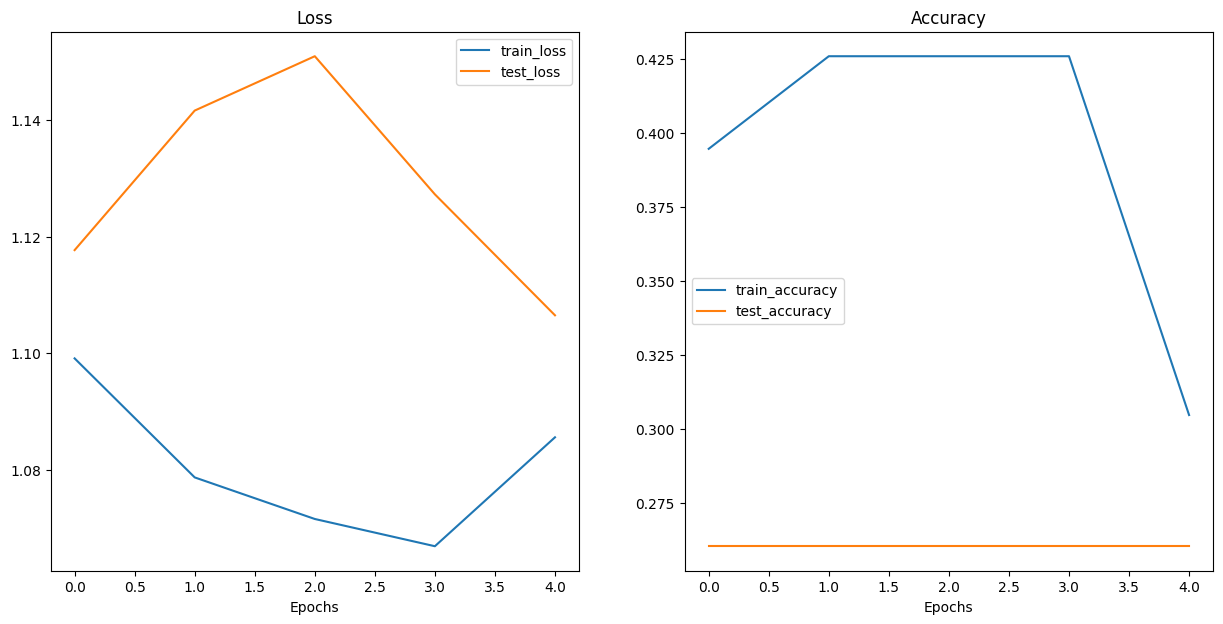

In [35]:
plot_loss_curves(model_0_results)

## Training Model with Data Augmentation

In [36]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [37]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [38]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7adaca67b6d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7adaca6ca6d0>)

In [39]:
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_dataset.classes)
)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [40]:
EPOCHS = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

start_time = timer()

model_1_results = train(
    model=model_1,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=EPOCHS
)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0977 | train_acc: 0.4180 | test_loss: 1.1144 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1072 | train_acc: 0.3047 | test_loss: 1.1348 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0949 | train_acc: 0.3047 | test_loss: 1.1349 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1012 | train_acc: 0.3008 | test_loss: 1.1473 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1091 | train_acc: 0.2930 | test_loss: 1.1204 | test_acc: 0.3021
Total training time: 8.973 seconds


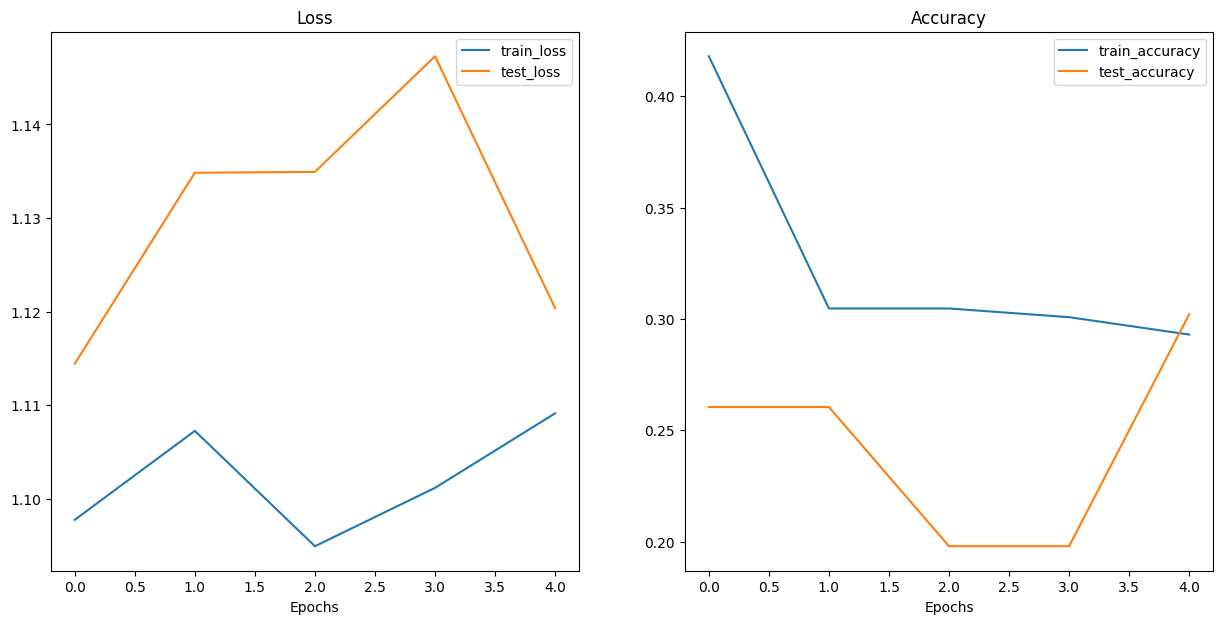

In [41]:
plot_loss_curves(model_1_results)

In [42]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

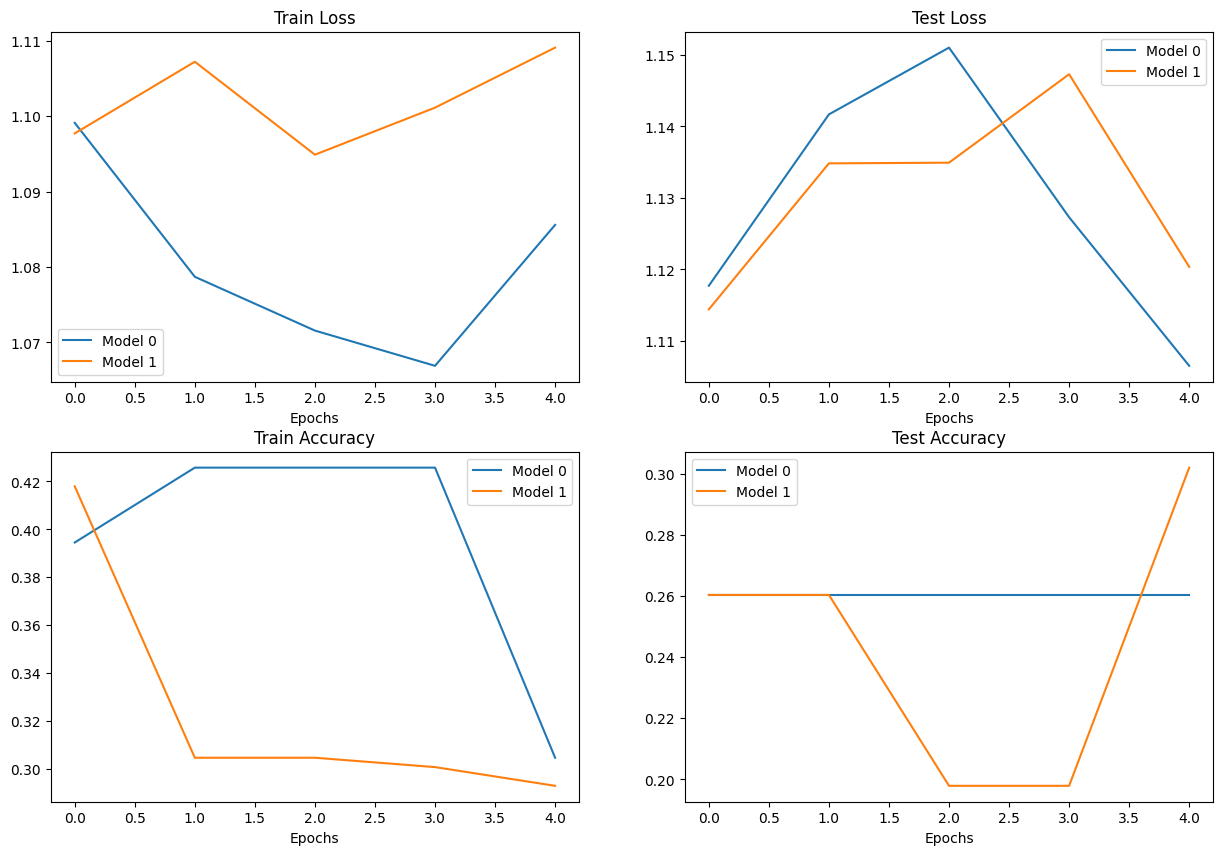

In [43]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();